In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv(r"C:\Users\PC\Desktop\6 projects\insurance.csv")

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


a.Handle Missing values


In [6]:
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


b. Handle Outliers

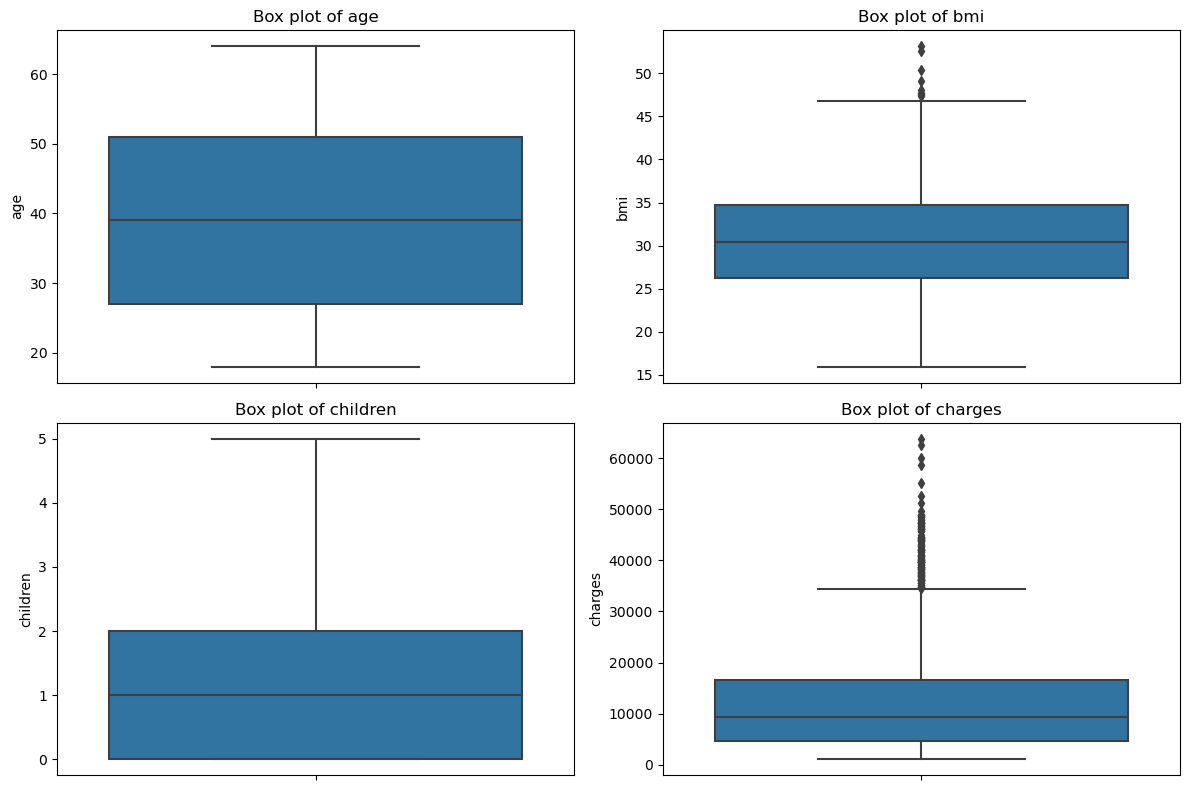

In [7]:
numerical_features = ['age', 'bmi', 'children', 'charges']


plt.figure(figsize=(12, 8))

for i, feature in enumerate(numerical_features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(y=df[feature])
    plt.title(f'Box plot of {feature}')

plt.tight_layout()
plt.show()

Well charges and bmi has some outlier so we will fix it 


In [8]:
numerical_features = ['age', 'bmi', 'children', 'charges']

Q1 = df[numerical_features].quantile(0.25)
Q3 = df[numerical_features].quantile(0.75)
IQR = Q3 - Q1

# Removing outliers
df = df[~((df[numerical_features] < (Q1 - 1.5 * IQR)) | (df[numerical_features] > (Q3 + 1.5 * IQR))).any(axis=1)]

c. Scaling

In [9]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[numerical_features])
df[numerical_features] = scaled_features
print(df[numerical_features].head)

<bound method NDFrame.head of            age       bmi  children   charges
0    -1.421407 -0.357841 -0.892872  0.957834
1    -1.492543  0.643111 -0.070327 -1.133608
2    -0.781184  0.511811  1.574764 -0.757808
3    -0.425504 -1.243693 -0.892872  1.661386
4    -0.496640 -0.190732 -0.892872 -0.838186
...        ...       ...       ...       ...
1333  0.783807  0.165655  1.574764  0.090819
1334 -1.492543  0.327649 -0.892872 -1.067327
1335 -1.492543  1.168313 -0.892872 -1.146814
1336 -1.279136 -0.715933 -0.892872 -1.094648
1337  1.566303 -0.158333 -0.892872  2.648776

[1193 rows x 4 columns]>


d. Feature Engineering

In [10]:
df = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)


e.Feature selection using VIF and P Value, R-squared and Adjusted R-squared

In [13]:
X = sm.add_constant(df.drop(columns=['charges']))
#VIF 
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


X = X.drop(columns=['const'])

# OLS model to get p-values
model = sm.OLS(df['charges'], X).fit()




selected_features = [feature for feature, pval in zip(X.columns, model.pvalues) if pval < 0.05]
print("Selected features based on p-value: ", selected_features)


X_selected = X[selected_features]

            Feature       VIF
0             const  5.204706
1               age  1.020910
2               bmi  1.161134
3          children  1.003043
4          sex_male  1.001592
5        smoker_yes  1.077156
6  region_northwest  1.515008
7  region_southeast  1.596693
8  region_southwest  1.517057
Selected features based on p-value:  ['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']


In [14]:
# Summary
print(model.summary())


                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.602
Model:                            OLS   Adj. R-squared (uncentered):              0.599
Method:                 Least Squares   F-statistic:                              223.6
Date:                Sat, 25 May 2024   Prob (F-statistic):                   1.26e-230
Time:                        17:58:14   Log-Likelihood:                         -1143.9
No. Observations:                1193   AIC:                                      2304.
Df Residuals:                    1185   BIC:                                      2344.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

Summary of the model

In [18]:
X = df[selected_features]
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
#assigning variable to our model
svm = SVR()

In [20]:
svm.fit(X_train, y_train)

SVR()

In [21]:
y_pred = svm.predict(X_test)

In [25]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2_score(y_test, y_pred))

Mean Squared Error: 0.3362899983110135
R-squared: 0.6304782249826044


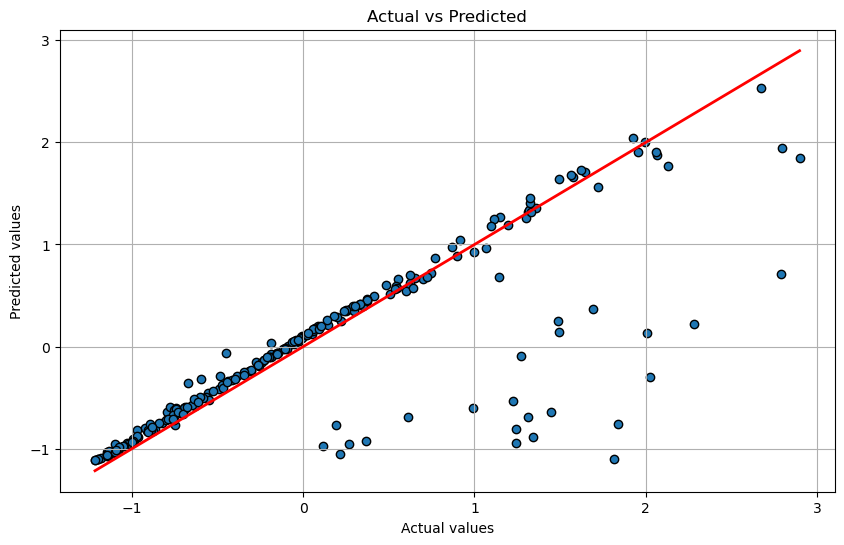

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', lw=2)
plt.title('Actual vs Predicted')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.grid(True)
plt.show()